In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Define the path to the dataset
dataset_path = '/content/drive/My Drive/industry_data.xlsx'

Mounted at /content/drive


In [ ]:
industry_df = pd.read_excel(dataset_path)

# Convert timestamp to datetime and remove microseconds
industry_df['timestamp'] = pd.to_datetime(industry_df['timestamp']).dt.floor('S')

# Display the first few rows of the dataset
industry_df.head()

,timestamp,machines,pressure
0,2023-06-01 15:00:00,4948,1426
1,2023-06-01 15:00:02,14031,9
2,2023-06-01 15:00:04,1,1389
3,2023-06-01 15:00:06,13,1004
4,2023-06-01 15:00:08,8,779


In [ ]:
industry_df.describe()

,timestamp,machines,pressure
count,5000,5000.000000,5.000000e+03
mean,2023-06-01 16:29:59.500599808,802.933200,7.748895e+05
min,2023-06-01 15:00:00,1.000000,0.000000e+00
25%,2023-06-01 15:44:59.500000,4.000000,4.147500e+02
50%,2023-06-01 16:29:59.500000,8.000000,8.315000e+02
75%,2023-06-01 17:14:59.500000,12.000000,1.248000e+03
max,2023-06-01 18:00:00,16135.000000,1.477435e+07
std,NaN,2789.412281,2.688270e+06


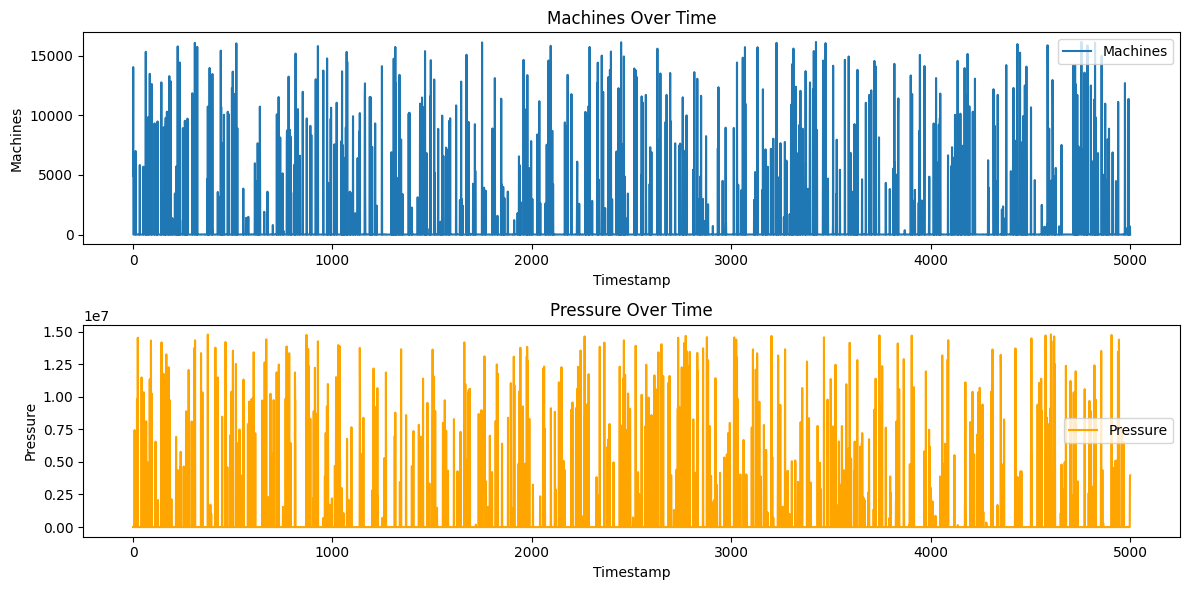

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(industry_df.index, industry_df['machines'], label='Machines')
plt.title('Machines Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Machines')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(industry_df.index, industry_df['pressure'], label='Pressure', color='orange')
plt.title('Pressure Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Pressure')
plt.legend()

plt.tight_layout()
plt.show()

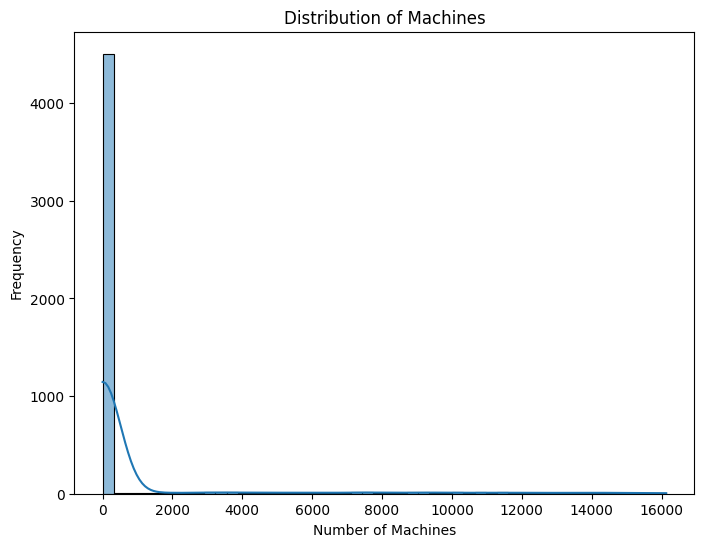

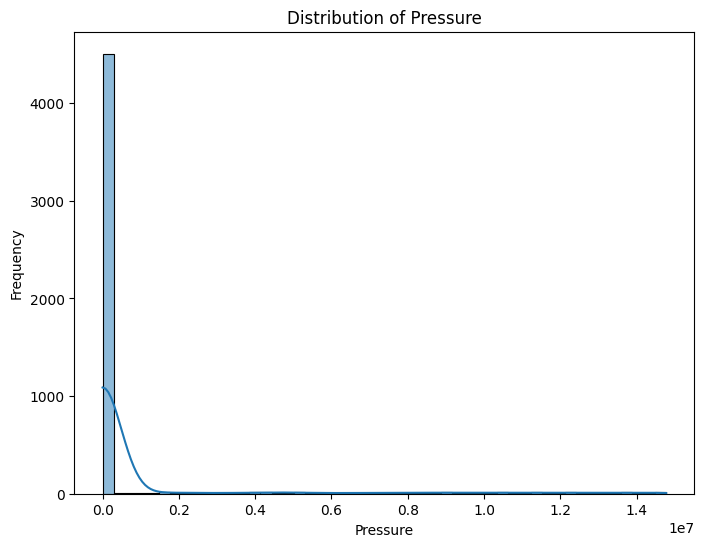

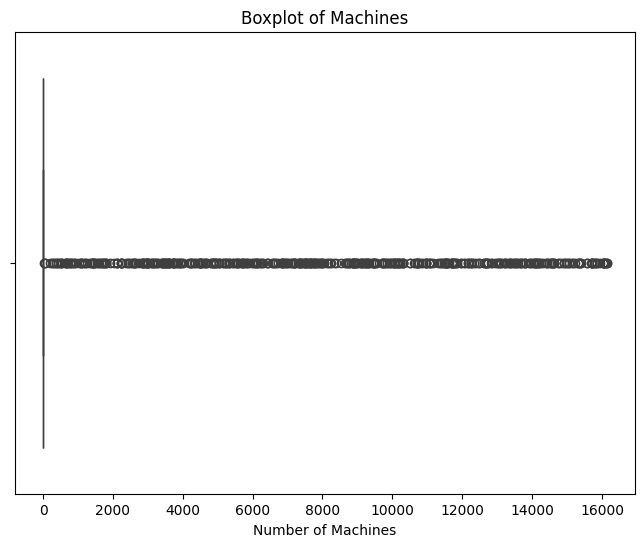

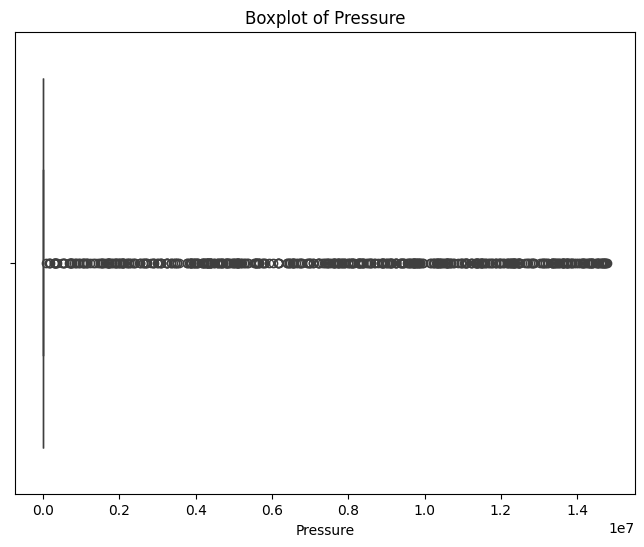

In [ ]:
# Plotting the distribution of 'machines'
plt.figure(figsize=(8, 6))
sns.histplot(industry_df['machines'], bins=50, kde=True)
plt.title('Distribution of Machines')
plt.xlabel('Number of Machines')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of 'pressure'
plt.figure(figsize=(8, 6))
sns.histplot(industry_df['pressure'], bins=50, kde=True)
plt.title('Distribution of Pressure')
plt.xlabel('Pressure')
plt.ylabel('Frequency')
plt.show()

# Plotting boxplots to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=industry_df['machines'])
plt.title('Boxplot of Machines')
plt.xlabel('Number of Machines')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=industry_df['pressure'])
plt.title('Boxplot of Pressure')
plt.xlabel('Pressure')
plt.show()

# IQR Method to detect the outliers

In [ ]:
# Calculate IQR for 'machines'
Q1_machines = industry_df['machines'].quantile(0.25)
Q3_machines = industry_df['machines'].quantile(0.75)
IQR_machines = Q3_machines - Q1_machines

# Calculate IQR for 'pressure'
Q1_pressure = industry_df['pressure'].quantile(0.25)
Q3_pressure = industry_df['pressure'].quantile(0.75)
IQR_pressure = Q3_pressure - Q1_pressure

In [ ]:
# Define outliers
outliers_machines = industry_df[(industry_df['machines'] < (Q1_machines - 1.5 * IQR_machines)) | (industry_df['machines'] > (Q3_machines + 1.5 * IQR_machines))]
outliers_pressure = industry_df[(industry_df['pressure'] < (Q1_pressure - 1.5 * IQR_pressure)) | (industry_df['pressure'] > (Q3_pressure + 1.5 * IQR_pressure))]

In [ ]:
# Combine outliers
outliers = pd.concat([outliers_machines, outliers_pressure]).drop_duplicates().reset_index(drop=True)

print(outliers)

              timestamp  machines  pressure
0   2023-06-01 15:00:00      4948      1426
1   2023-06-01 15:00:02     14031         9
2   2023-06-01 15:00:28      7001      1093
3   2023-06-01 15:01:13      5828       880
4   2023-06-01 15:01:52      5689       254
..                  ...       ...       ...
934 2023-06-01 17:57:54         4   9972185
935 2023-06-01 17:57:59         7  14379324
936 2023-06-01 17:58:29         2   7612001
937 2023-06-01 17:58:48        13   6517057
938 2023-06-01 18:00:00        10   3967339

[939 rows x 3 columns]


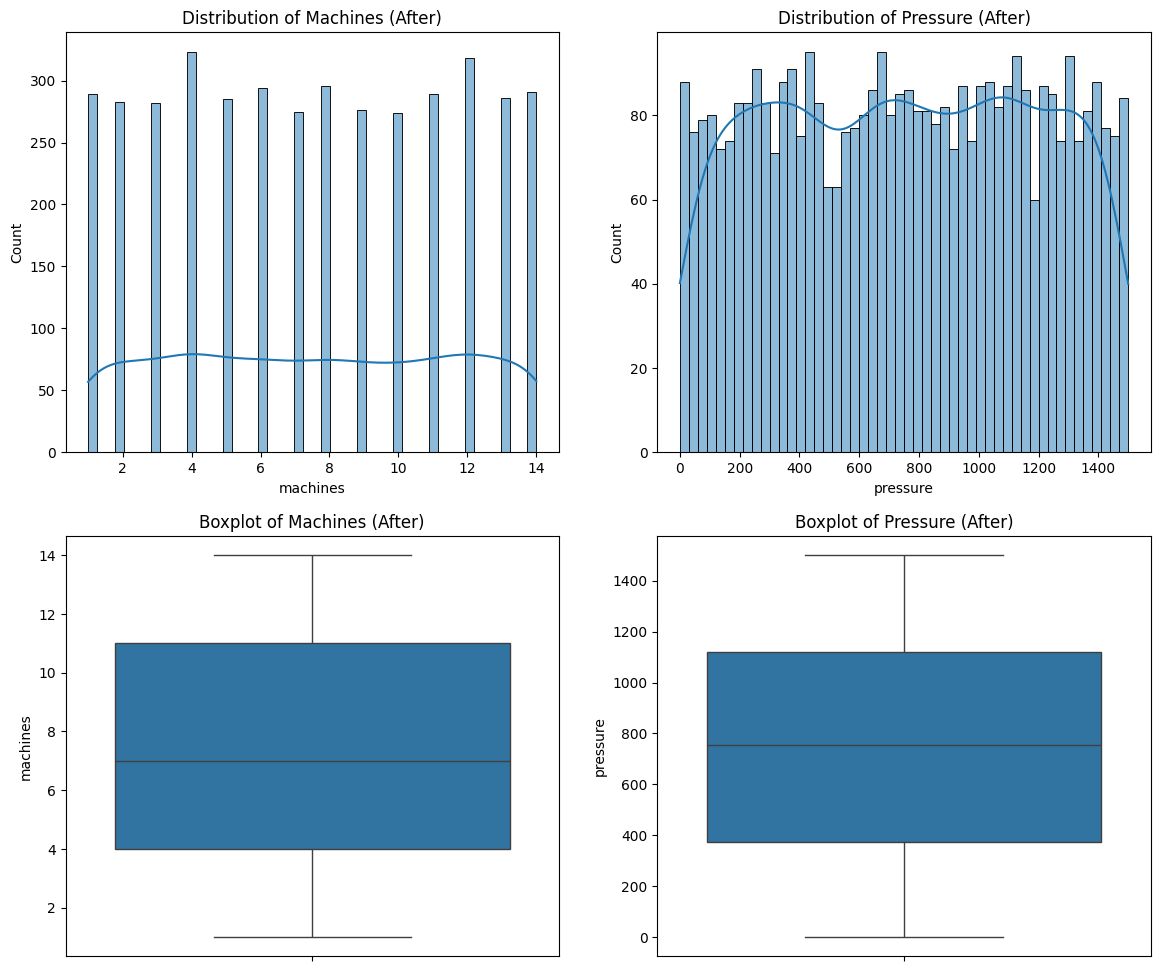

In [ ]:
# Remove outliers
industry_df_no_outliers = industry_df[~industry_df.index.isin(outliers_machines.index) & ~industry_df.index.isin(outliers_pressure.index)]

# Plot distribution of 'machines' and 'pressure' after removing outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(industry_df_no_outliers['machines'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Machines (After)')
sns.histplot(industry_df_no_outliers['pressure'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Pressure (After)')
sns.boxplot(industry_df_no_outliers['machines'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Machines (After)')
sns.boxplot(industry_df_no_outliers['pressure'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Pressure (After)')
plt.show()

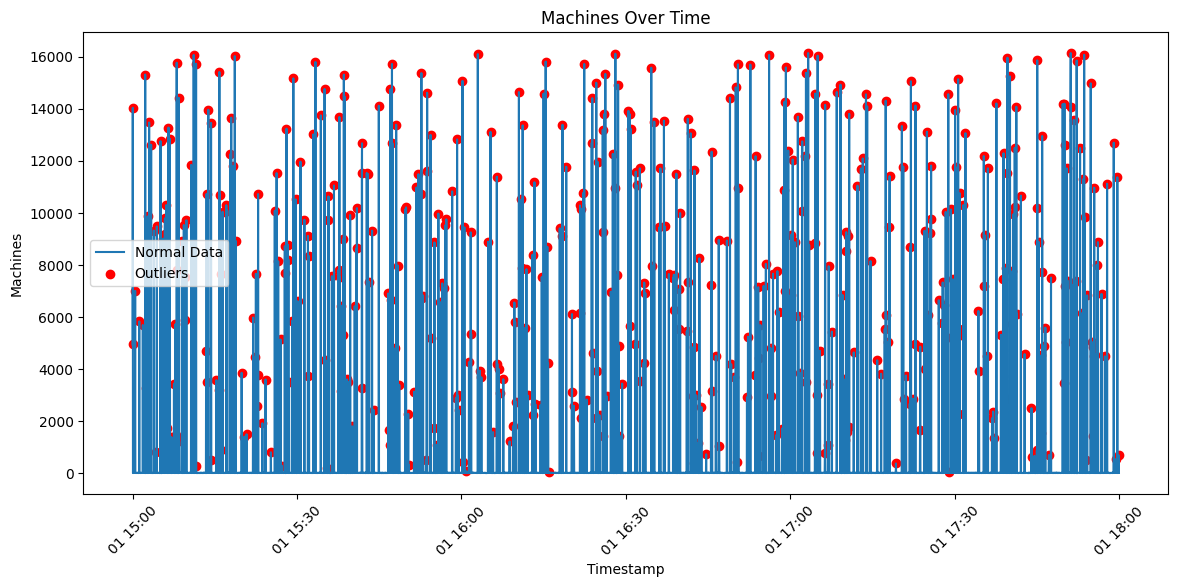

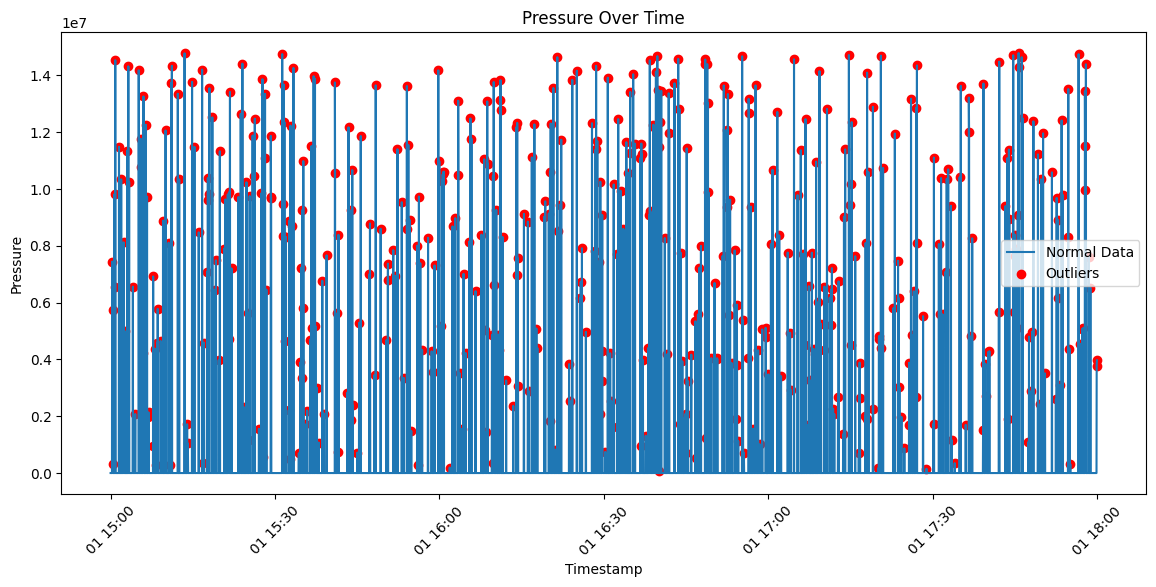

In [ ]:
# Plot machines over time with outliers highlighted
plt.figure(figsize=(14, 6))
plt.plot(industry_df['timestamp'], industry_df['machines'], label='Normal Data')
plt.scatter(outliers_machines['timestamp'], outliers_machines['machines'], color='red', label='Outliers')
plt.title('Machines Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Machines')
plt.legend()
plt.xticks(rotation=45)
plt.show()
# Plot pressure over time with outliers highlighted
plt.figure(figsize=(14, 6))
plt.plot(industry_df['timestamp'], industry_df['pressure'], label='Normal Data')
plt.scatter(outliers_pressure['timestamp'], outliers_pressure['pressure'], color='red', label='Outliers')
plt.title('Pressure Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Pressure')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Isolation Forest Method

In [ ]:
random_state = np.random.RandomState(42)
model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=random_state)
model.fit(industry_df[['machines', 'pressure']])
print(model.get_params())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


{'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7D3D70113140, 'verbose': 0, 'warm_start': False}


In [ ]:
industry_df['scores'] = model.decision_function(industry_df[['machines', 'pressure']])
industry_df['anomaly_score'] = model.predict(industry_df[['machines', 'pressure']])
industry_df[industry_df['anomaly_score']==-1]

,timestamp,machines,pressure,scores,anomaly_score
0,2023-06-01 15:00:00,4948,1426,-0.221588,-1
1,2023-06-01 15:00:02,14031,9,-0.288799,-1
8,2023-06-01 15:00:17,9,7440451,-0.224778,-1
10,2023-06-01 15:00:21,5,303219,-0.111042,-1
12,2023-06-01 15:00:25,9,5736410,-0.232551,-1
...,...,...,...,...,...
4973,2023-06-01 17:59:03,12691,699,-0.240718,-1
4984,2023-06-01 17:59:27,539,871,-0.087367,-1
4991,2023-06-01 17:59:42,11362,665,-0.230670,-1
4998,2023-06-01 17:59:57,688,3775428,-0.279901,-1


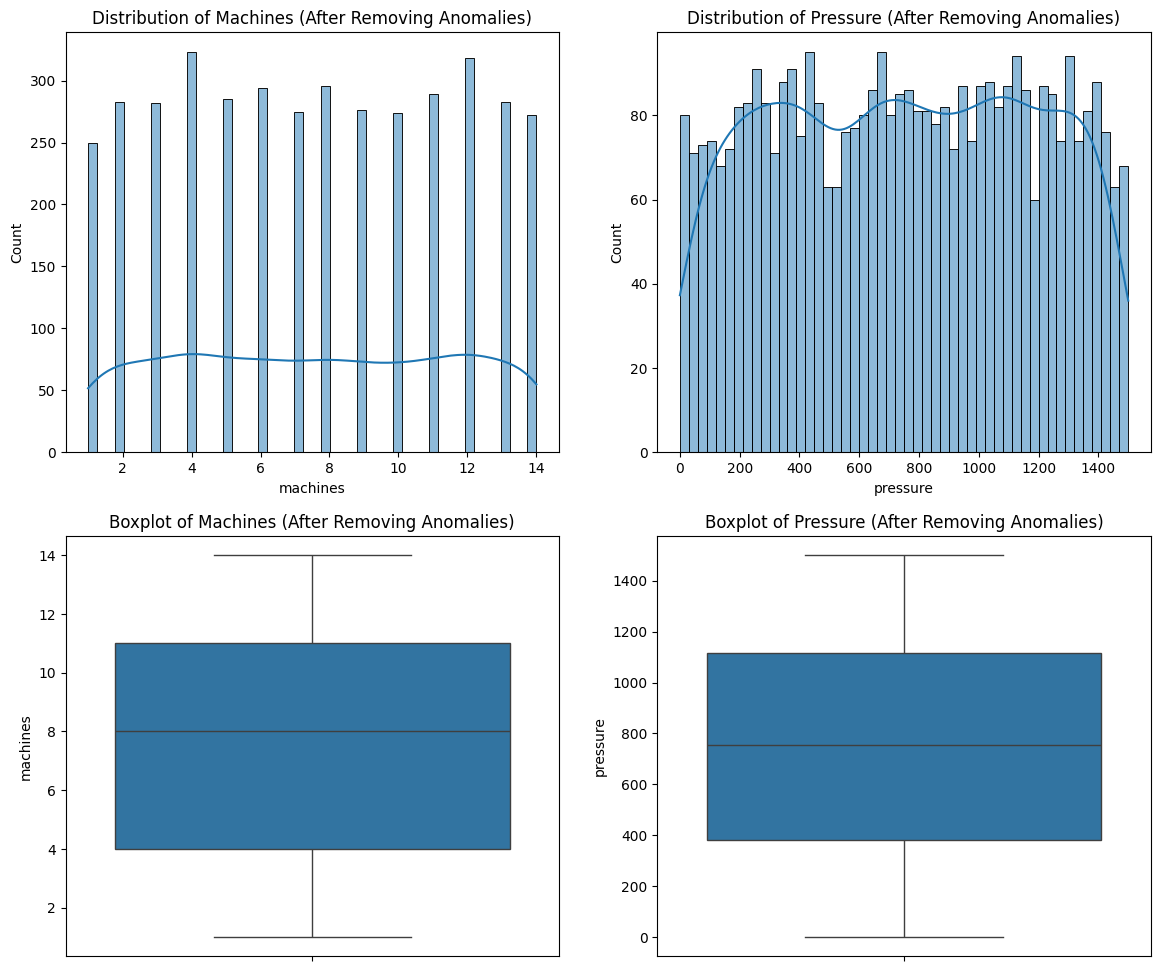

In [ ]:
# Remove detected anomalies
industry_df_no_anomalies = industry_df[industry_df['anomaly_score'] != -1]

# Plot distribution of 'machines' and 'pressure' after removing anomalies
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(industry_df_no_anomalies['machines'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Machines (After Removing Anomalies)')
sns.histplot(industry_df_no_anomalies['pressure'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Pressure (After Removing Anomalies)')
sns.boxplot(industry_df_no_anomalies['machines'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Machines (After Removing Anomalies)')
sns.boxplot(industry_df_no_anomalies['pressure'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Pressure (After Removing Anomalies)')
plt.show()


# Auto-encoders

In [ ]:
# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(industry_df[['machines', 'pressure']])

In [ ]:
# Split data into training and test sets
#X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=42)

In [ ]:
# Define the autoencoder model
input_dim = scaled_data.shape[1]
encoding_dim = 2  # Dimensionality of the encoding space

In [ ]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the autoencoder
history = autoencoder.fit(scaled_data, scaled_data, epochs=100, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 1.1453 - val_loss: 1.0794
Epoch 2/100
125/125 [==============================] - 1s 4ms/step - loss: 1.0467 - val_loss: 0.9800
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9584 - val_loss: 0.8997
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 0.8914 - val_loss: 0.8415
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 0.8446 - val_loss: 0.8018
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 0.8127 - val_loss: 0.7745
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 0.7906 - val_loss: 0.7554
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - loss: 0.7745 - val_loss: 0.7411
Epoch 9/100
125/125 [==============================] - 0s 3ms/step - loss: 0.7622 - val_loss: 0.7299
Epoch 10/100
125/125 [==============================] - 0s 3ms/step - loss: 0.7521 - val_lo

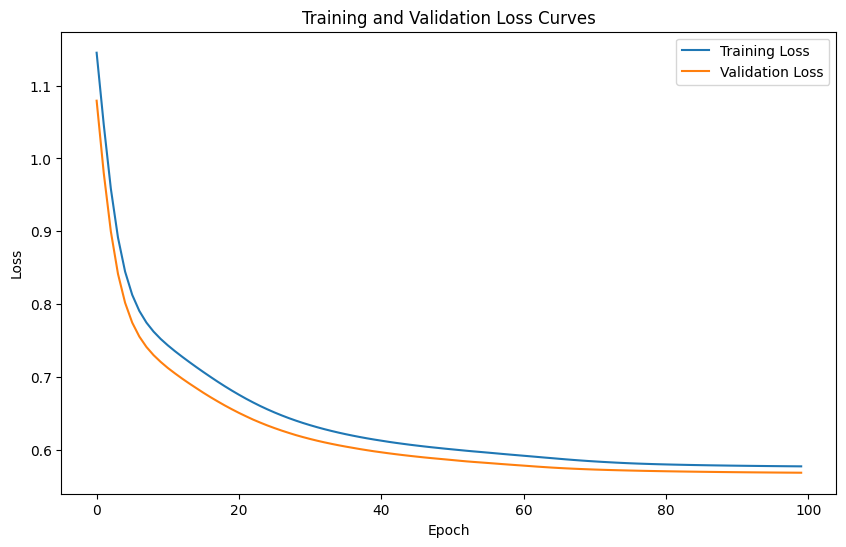

In [ ]:
# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
# Get reconstruction errors
test_predictions = autoencoder.predict(scaled_data)
reconstruction_errors = np.mean(np.power(test_predictions - scaled_data, 2), axis=1)

157/157 [==============================] - 1s 3ms/step


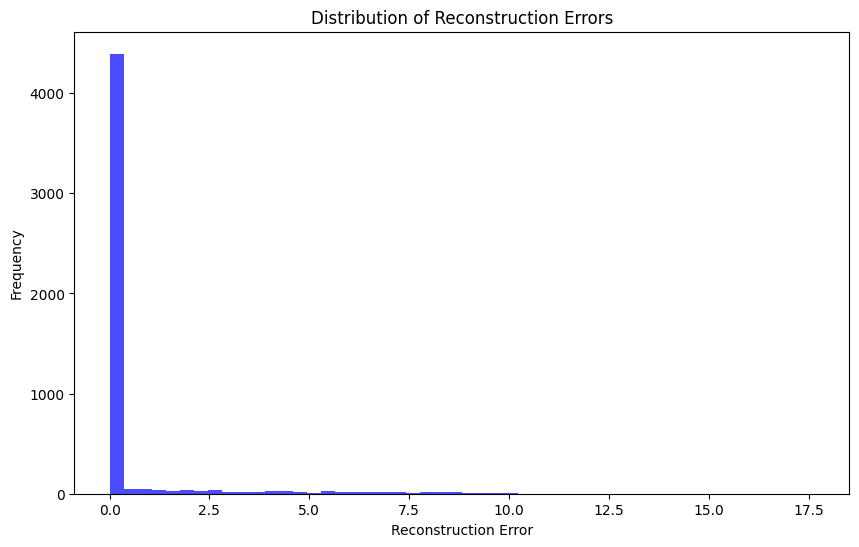

In [ ]:
# Plot the reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Choose a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 80)  # Adjust this threshold based on your needs
print(f"Chosen threshold: {threshold}")

# Create a DataFrame for test data with reconstruction errors
test_anomalies = pd.DataFrame(scaler.inverse_transform(scaled_data), columns=['machines', 'pressure'])
test_anomalies['timestamp'] = industry_df['timestamp'].iloc[-len(scaled_data):].values
test_anomalies['reconstruction_error'] = reconstruction_errors
test_anomalies['anomaly'] = test_anomalies['reconstruction_error'] > threshold

# Filter detected anomalies
detected_anomalies = test_anomalies[test_anomalies['anomaly']]

# Print the detected anomalies
print("Detected anomalies:")
print(detected_anomalies[['timestamp', 'machines', 'pressure', 'reconstruction_error']])
detected_anomalies.count()

Chosen threshold: 0.08295598863874071
Detected anomalies:
               timestamp  machines   pressure  reconstruction_error
0    2023-06-01 15:00:00    4948.0     1426.0              0.159916
1    2023-06-01 15:00:02   14031.0        9.0              7.045875
8    2023-06-01 15:00:17       9.0  7440451.0              1.148783
12   2023-06-01 15:00:25       9.0  5736410.0              0.408265
13   2023-06-01 15:00:28    7001.0     1093.0              0.788509
...                  ...       ...        ...                   ...
4957 2023-06-01 17:58:29       2.0  7612001.0              1.246363
4965 2023-06-01 17:58:46       1.0      549.0              0.083032
4966 2023-06-01 17:58:48      13.0  6517057.0              0.697190
4973 2023-06-01 17:59:03   12691.0      699.0              5.363024
4991 2023-06-01 17:59:42   11362.0      665.0              3.922055

[1000 rows x 4 columns]


machines                1000
pressure                1000
timestamp               1000
reconstruction_error    1000
anomaly                 1000
dtype: int64

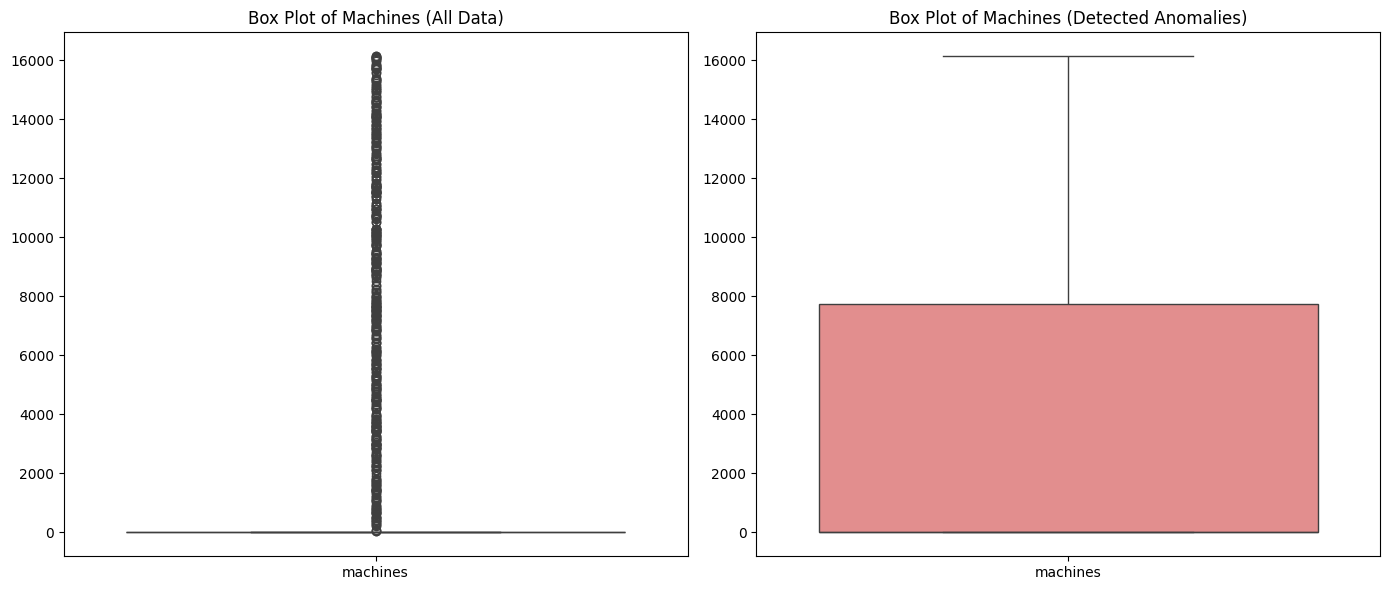

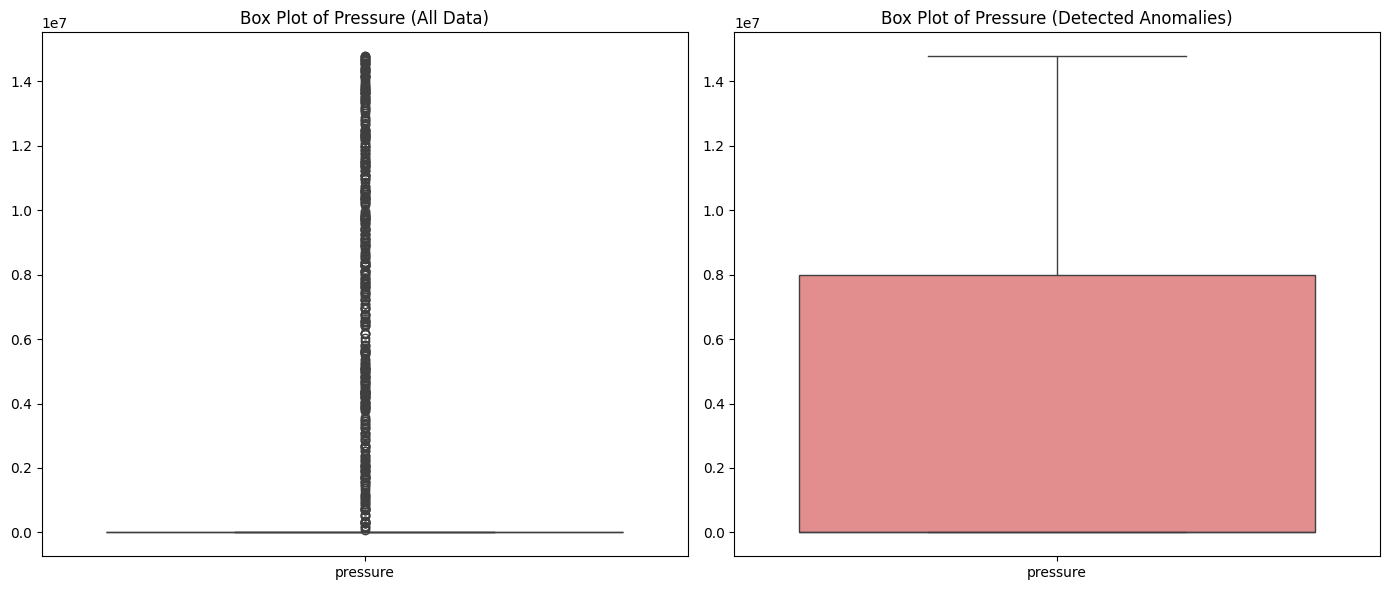

In [ ]:
# Plot the box plot of machines and pressure before and after anomaly detection
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=industry_df[['machines']], color='lightgreen')
plt.title('Box Plot of Machines (All Data)')

plt.subplot(1, 2, 2)
sns.boxplot(data=detected_anomalies[['machines']], color='lightcoral')
plt.title('Box Plot of Machines (Detected Anomalies)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=industry_df[['pressure']], color='lightgreen')
plt.title('Box Plot of Pressure (All Data)')

plt.subplot(1, 2, 2)
sns.boxplot(data=detected_anomalies[['pressure']], color='lightcoral')
plt.title('Box Plot of Pressure (Detected Anomalies)')

plt.tight_layout()
plt.show()